In [115]:
import sys
import os
from utils.utils import *
from pathlib import Path

# Add parent directory temporarily to sys.path
sys.path.insert(0, str(Path(os.getcwd()).resolve().parent))

In [116]:
from __future__ import annotations

import warnings
from itertools import chain
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from tqdm import tqdm

from lib.Simulation import Simulation
from lib.Simulation_gpu import Simulation as Simulation_GPU
from lib.Loader import Loader
from lib.nn.helper import SaveLoad, BatchProcessing
from lib.nn.nets import FCN, MShuffle
from lib.nn.netsdd import LinearDD, SoftplusDD, FCNDD, MShuffleDD
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path = "experiment2___"

In [54]:
np.random.seed(20)

dt, dx, dy = (0.01, 0.01, 0.01)

A = np.load(r"C:\Users\Alex\Desktop\data-experimental\data-non-equal-case\states.npy")
Nt, Nx, Ny = A.shape
Lt, Lx, Ly = Nt*dt, Nx*dx, Ny*dy 
myu_size = A.shape
u = A

In [55]:
myu = np.load(r"C:\Users\Alex\Desktop\data-experimental\data-non-equal-case\myu.npy")

In [134]:
import torch
from lib.Loader import Loader

class DatasetLoader(Loader):
    def __init__(self, X, Y, T, A):
        self.X = torch.tensor(X, dtype=torch.float32).view(-1).to(device)
        self.Y = torch.tensor(Y, dtype=torch.float32).view(-1).to(device)
        self.T = torch.tensor(T, dtype=torch.float32).view(-1).to(device)
        self.XYT = torch.stack((self.X, self.Y, self.T), dim=1)
        
        A_real = torch.tensor(A.real, dtype=torch.float32).view(-1).to(device)
        A_imag = torch.tensor(A.imag, dtype=torch.float32).view(-1).to(device)
        self.A = torch.stack((A_real, A_imag), dim=1).to(device)
        self._setmyu = False
        
    def set_myu(self, myu):
        self._setmyu = True
        self.myu = myu

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, slice):
        if self._setmyu: return self.XYT[slice], self.A[slice], self.myu[slice]
        return self.XYT[slice], self.A[slice]

In [135]:
class DatasetLoaderDD(DatasetLoader):
    def __getitem__(self, slice):
        result = super().__getitem__(slice)
        (xyt, *rest) = result
        dxyt = torch.tensor([[0,0,1],[1,0,0],[0,1,0]], dtype = torch.float32).unsqueeze(1).repeat(1, self.batch_size, 1).to(device)
        ddxyt = torch.tensor([[0,0,0],[0,0,0],[0,0,0]], dtype = torch.float32).unsqueeze(1).repeat(1, self.batch_size, 1).to(device)
        return ((xyt,dxyt,ddxyt), *rest)

In [136]:
x = np.linspace(-Lx, Lx, Nx).flatten()[:, None]/2
y = np.linspace(-Ly, Ly, Ny).flatten()[:, None]/2
t = np.linspace(0, Lt, Nt).flatten()[:, None]

X, T, Y = np.meshgrid(x, t, y)
dldd = DatasetLoaderDD(X,Y,T,A)

In [137]:
class PCNNDD(nn.Module, SaveLoad, BatchProcessing):
    def __init__(self, device = 'cpu'):
        super(PCNNDD, self).__init__()
        self.encoder = FCNDD(layers_list = [3,512]).to(device)
        self.decoder = FCNDD(layers_list = [512,2]).to(device)
        self.shuffler = MShuffleDD(exp_size = 9, n_depth = 4 ).to(device)
        self.optimizer = torch.optim.Adam(params = chain(
            self.encoder._Wtmx.parameters(),
            self.shuffler._Wtmx.parameters(),
            self.decoder._Wtmx.parameters(),
            ), lr=0.01)
        
    def forward(self, x):
        E = self.encoder.forward(x)
        S = self.shuffler.forward(E)
        return self.decoder.forward(S)

In [138]:
class PINNDD(PCNNDD):
    def __init__(self, *args, device = 'cpu', **kwargs):
        super(PINNDD, self).__init__(*args, device = device, **kwargs)
        self.device = device 
        mNt,mNx,mNy = myu_size
        self.mshape = (Nt, mNx, mNy)
        self.scale = (Nx//mNx, Ny//mNy)
        self.myureset()
    

    def myureset(self):
        myu = torch.abs(torch.randn(*self.mshape, dtype=torch.float32).to(self.device))
        myu = nn.Parameter(myu)
        self.myuparam = myu
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=self.scale, mode='nearest').squeeze()
        return myu
    
    def save_myu(self,filename):
        myu = self.myuparam.cpu().detach().numpy()
        np.save(filename, myu)
        
    def load_myu(self,filename):
        myu = np.load(filename)
        myuparam = torch.tensor(myu, dtype=torch.float32).to(self.device)
        self.myuparam = nn.Parameter(myuparam)

In [139]:
def fmse_mse_batch_train(self, dataloader, lr=0.01, verbose=1, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(self.parameters(), lr=lr)
    
    all_losses = []

    for inputs, outputs, myu in dataloader:
        optimizer.zero_grad()

        net_myu = myu.view(-1,1)
        
        u, (u_t, y_x, u_y), (u_tt, u_xx, u_yy) = self(inputs)
        
        loss = criterion(u, outputs)


        f = u_t - u_xx - u_yy + torch.pow(torch.abs(u), 2).sum(dim=1, keepdim=True) * u  - u * net_myu
        floss = torch.mean(f**2)

        loss.backward()
        optimizer.step()
            

        all_losses.append((loss.item(),floss.item()))
    
    return all_losses

## Training the model and get approximate myus

In [140]:
torch.manual_seed(1)
net = PINNDD(device = device)
net.device = device
dldd.set(epochs = 20000, batch_size = 4000, shuffle=True, verbose = 2, device = device)

In [141]:
M = net.myu.view(-1, 1)

In [142]:
dldd.set_myu(M)

In [143]:
M.shape, dldd.XYT.shape

(torch.Size([32396000, 1]), torch.Size([32396000, 3]))

In [144]:
lr = 1e-3
L = fmse_mse_batch_train(net, dataloader = dldd, verbose = 1, device = device, lr = lr)


 41%|████      | 8105/20000 [03:30<11:06, 17.85it/s]

Next full iteration over the entire dataset


100%|██████████| 20000/20000 [07:26<00:00, 44.76it/s]


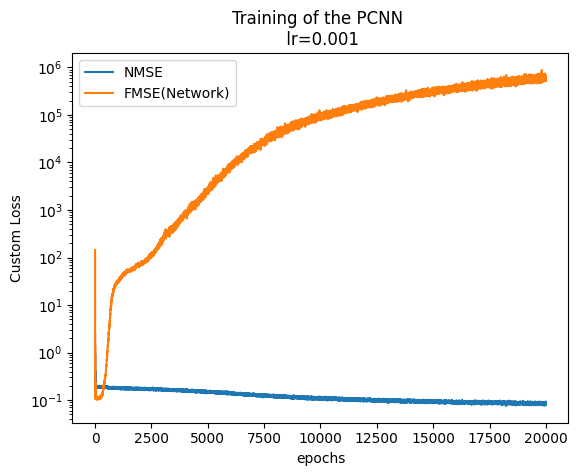

In [145]:
plt.plot(L, label = ("NMSE", "FMSE(Network)"))
plt.legend()
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title(f'Training of the PCNN \n lr={lr}')
plt.savefig(f'{path}_{lr}.png')

In [146]:
lr = 3e-4
L = fmse_mse_batch_train(net, dataloader = dldd, verbose = 1, device = device, lr = lr)

 41%|████      | 8106/20000 [02:42<09:51, 20.11it/s]

Next full iteration over the entire dataset


100%|██████████| 20000/20000 [06:37<00:00, 50.37it/s]


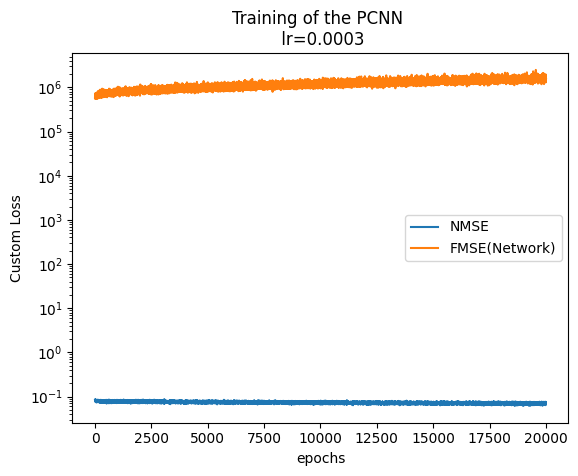

In [147]:
plt.plot(L, label = ("NMSE", "FMSE(Network)"))
plt.legend()
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title(f'Training of the PCNN \n lr={lr}')
plt.savefig(f'{path}_{lr}.png')

In [148]:
import os
if not os.path.exists(f"{path}.pt"):
    net.save_model(f"{path}.pt")

Model saved to experiment2___.pt


## calculating myus

In [149]:
import numpy as np

def loader_predict(self, dataloader, complex = True):
    All = {
        'u': [],
        'u_t': [],
        'u_x': [],
        'u_y': [],
        'u_tt': [],
        'u_xx': [],
        'u_yy': [],
        'net_myu': []
    }

    for inputs, outputs, myu in dataloader:
        net_myu = myu.view(-1, 1)
        
        u, (u_t, u_x, u_y), (u_tt, u_xx, u_yy) = self(inputs)

        All['u'].append(u.cpu().detach().numpy())
        All['u_t'].append(u_t.cpu().detach().numpy())
        All['u_x'].append(u_x.cpu().detach().numpy())
        All['u_y'].append(u_y.cpu().detach().numpy())
        All['u_tt'].append(u_tt.cpu().detach().numpy())
        All['u_xx'].append(u_xx.cpu().detach().numpy())
        All['u_yy'].append(u_yy.cpu().detach().numpy())
        All['net_myu'].append(net_myu.cpu().detach().numpy())
    
    # Convert lists to numpy arrays
    All = {key: np.concatenate(value, axis=0) for key, value in All.items()}

    if complex:
        # Convert to complex numbers after converting to numpy arrays
        All['u'] = All['u'][:, 0] + All['u'][:, 1] * 1j
        All['u_t'] = All['u_t'][:, 0] + All['u_t'][:, 1] * 1j
        All['u_x'] = All['u_x'][:, 0] + All['u_x'][:, 1] * 1j
        All['u_y'] = All['u_y'][:, 0] + All['u_y'][:, 1] * 1j
        All['u_tt'] = All['u_tt'][:, 0] + All['u_tt'][:, 1] * 1j
        All['u_xx'] = All['u_xx'][:, 0] + All['u_xx'][:, 1] * 1j
        All['u_yy'] = All['u_yy'][:, 0] + All['u_yy'][:, 1] * 1j
    
    return (All['u'],(All['u_t'], All['u_x'], All['u_y']),(All['u_tt'], All['u_xx'], All['u_yy']),(All['net_myu']))


In [168]:
batch_size = 4000
dldd.set(epochs = len(dldd)//batch_size, batch_size=batch_size,shuffle=False, verbose=1)


In [169]:
u, (u_t, u_x, u_y), (u_tt, u_xx, u_yy), (net_myu) = loader_predict(net,dldd)


100%|██████████| 8099/8099 [02:08<00:00, 62.82it/s]


In [170]:
u, u_t, u_x, u_y, u_tt, u_xx, u_yy, net_myu = u.reshape(A.shape), u_t.reshape(A.shape), u_x.reshape(A.shape), u_y.reshape(A.shape), u_tt.reshape(A.shape), u_xx.reshape(A.shape), u_yy.reshape(A.shape), net_myu.reshape(A.shape)

100%|██████████| 40/40 [00:14<00:00,  2.75it/s]


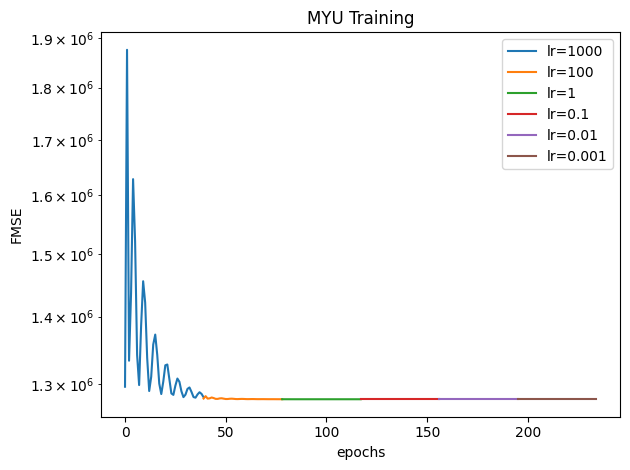

In [172]:
i = 0
L = []
pref = u_t - u_xx - u_yy + (np.abs(u) ** 2) * u
pref = torch.tensor(pref).to(device)
U = torch.tensor(u).to(device)

for idx, lr in enumerate([1000, 100, 1, 0.1, 0.01, 0.001]):

    myuoptimizer = torch.optim.Adam(params=[net.myuparam], lr=lr)
    myuoptimizer.zero_grad()

    FL = []
    for _ in tqdm(range(40)):
        f = pref - U * torch.abs(net.myu)
        FMSE = (torch.abs(f) ** 2).mean()
        FMSE.backward(retain_graph=True)
        FL.append(FMSE.cpu().detach().numpy())
        myuoptimizer.step()
        myuoptimizer.zero_grad()

        # myu constraints
        if idx >= 3:
            myu_array = net.myu.detach().cpu().numpy()

            mean_val = np.mean(myu_array)
            std_val = np.std(myu_array)

            peak1 = mean_val + std_val
            peak2 = mean_val - std_val

            tmp = np.where((myu_array >= peak2) & (myu_array <= peak1), 255, 0)
            net.myu.data = torch.tensor(tmp, dtype=torch.float32).to(device)

    plt.plot(range(i, i + len(FL)), FL, label=f"lr={lr}")
    i += len(FL) - 1

plt.yscale("log")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("FMSE")
plt.title("MYU Training")
plt.tight_layout()
plt.savefig(f"{path}_myutraining.png")
plt.show()

In [173]:
np.count_nonzero(np.unique(net.myu.detach().cpu().numpy()))

28399913

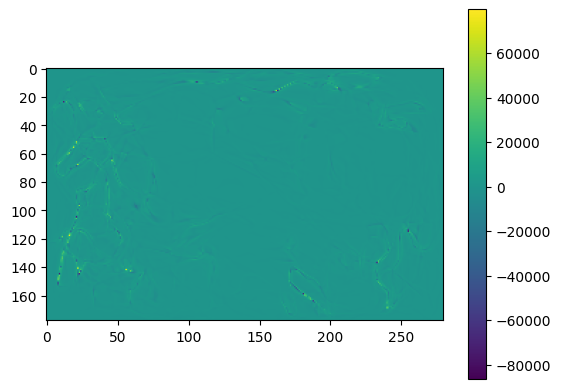

In [179]:
plt.imshow(net.myu.detach().cpu().numpy()[450])
plt.colorbar()

2900.619140625
-1983.0194091796875


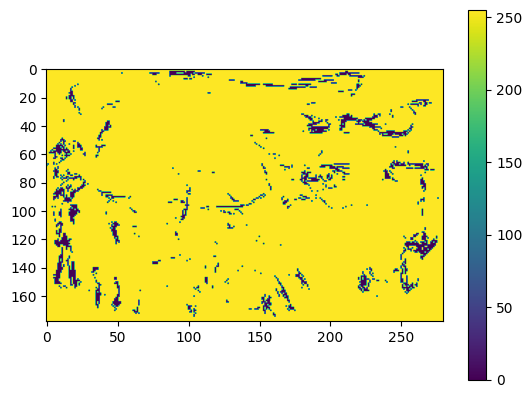

In [181]:
myu_array = net.myu.detach().cpu().numpy()

mean_val = np.mean(myu_array)
std_val = np.std(myu_array)

peak1 = mean_val + std_val
peak2 = mean_val - std_val
print(f"{peak1}")
print(f"{peak2}")

tmp = np.where((myu_array >= peak2) & (myu_array <= peak1), 255, 0)

plt.imshow(tmp[0])
plt.colorbar()
plt.show()

## FMSE Full Train

In [182]:
import os
if os.path.exists(f"{path}.pt"):
    net.load_model(f"{path}.pt")

Model loaded from experiment2___.pt


## Visualizing and saving plot gifs

In [183]:
class PCNN(nn.Module, SaveLoad, BatchProcessing):
    def __init__(self, device = 'cpu'):
        super(PCNN, self).__init__()
        self.encoder = FCN(layers_list = [3,512]).to(device)
        self.decoder = FCN(layers_list = [512,2]).to(device)
        self.shuffler = MShuffle(exp_size = 9, n_depth = 4 ).to(device)
        self.optimizer = torch.optim.Adam(params = chain(
            self.encoder._Wtmx.parameters(),
            self.shuffler._Wtmx.parameters(),
            self.decoder._Wtmx.parameters(),
            ), lr=0.01)
        
    def forward(self, x):
        E = self.encoder.forward(x)
        S = self.shuffler.forward(E)
        return self.decoder.forward(S)

In [184]:
lightnet = PCNN().to(device)
sd = net.state_dict()
del sd['myuparam']
lightnet.load_state_dict(sd)

<All keys matched successfully>

In [185]:
module_sq = lambda a: np.real(a)**2 + np.imag(a)**2
phase = lambda a: np.arcsin(np.real(a)/np.sqrt(np.real(a)**2+np.imag(a)**2))
real_imag = lambda a: np.real(a)*np.imag(a)
real = lambda a: np.real(a)
imag = lambda a: np.imag(a)

funlist_name = ["module_sq", "phase","real_imag","real","imag"]
funlist = [module_sq, phase, real_imag, real, imag]

myupred = net.myu.cpu().detach().numpy()
A = A
A_pred = lightnet.batch_predict(dldd.XYT,verbose = 1).reshape(A.shape)

Batch Prediction: 100%|██████████| 495/495 [00:14<00:00, 33.64it/s]


In [186]:
ATenzor = np.array([np.stack([
                    np.stack([fun(A) for fun in funlist]),
                    np.stack([fun(Ap) for fun in funlist])
                    ]) for A, Ap in zip(A, A_pred)])
                    

In [189]:
MTenzor = np.array([np.array([np.clip(mp, -1,1),np.clip(mp, -1e3,1e3)]) for m, mp in zip(myupred,myupred)])

In [191]:
AMTenzor = np.concatenate((MTenzor[:, :, np.newaxis, :, :], ATenzor), axis=2)

In [192]:
from lib.Video import create_video
create_video(AMTenzor[::2], titles=[['myu'] + funlist_name] * 2, videotitle = f'{path}.mp4')

Video successfully saved at experiment2___.mp4


In [188]:
np.min(myupred)

0.0

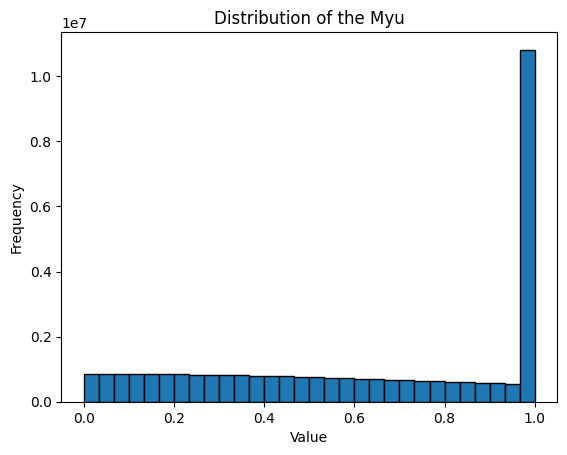

In [190]:
plt.hist(np.clip(myupred, -1, 1).reshape(-1), bins=30, edgecolor='black')
plt.title('Distribution of the Myu')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
